# Optimizing over non-float Parameters

Sometimes, you need to optimize a target that is not just a function of floating-point values, but relies on integer or categorical parameters. This notebook shows how such problems are handled by following an approach from ["Dealing with categorical and integer-valued variables in Bayesian Optimization with Gaussian processes" by Garrido-Merchán and Hernández-Lobato](https://arxiv.org/abs/1805.03463). One simple way of handling an integer-valued parameter is to run the optimization as normal, but then round to the nearest integer after a point has been suggested. This method is similar, except that the rounding is performed in the _kernel_. Why does this matter? It means that the kernel is aware that two parameters, that map the to same point but are potentially distinct before this transformation are the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from bayes_opt import acquisition

from sklearn.gaussian_process.kernels import Matern

## 1. Simple integer-valued function
Let's look at a simple, one-dimensional, integer-valued target function and compare a typed optimizer and a continuous optimizer.

/var/folders/r0/12hxq7zs2mx5kr76ks1_n9k80000gn/T/ipykernel_63433/3876025054.py:9: UserWarning: Non-float parameters are experimental and may not work as expected. Exercise caution when using them and please report any issues you encounter.
  bo_disc = BayesianOptimization(target_function_1d, d_pbounds, verbose=0)


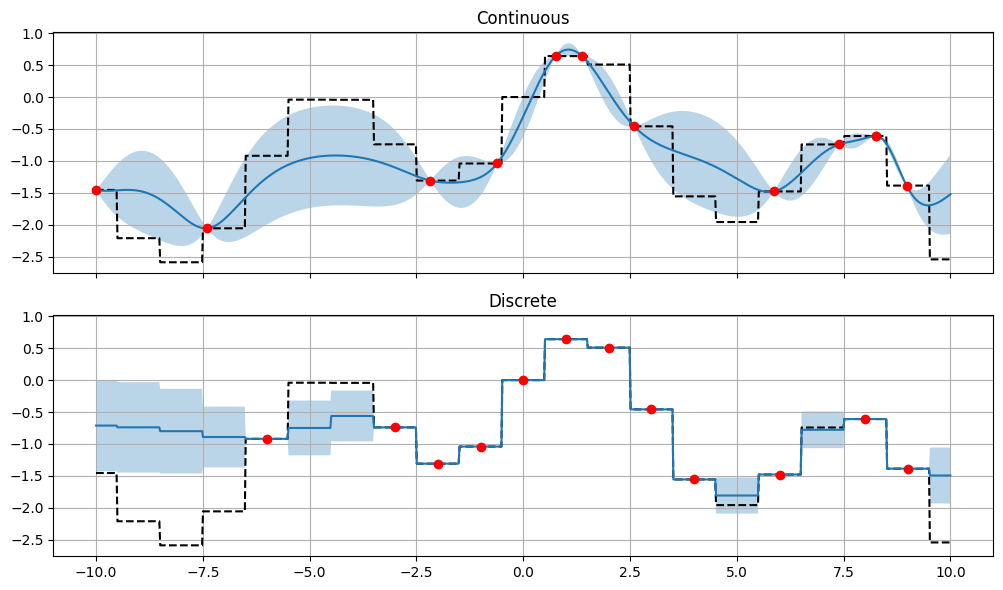

In [2]:
def target_function_1d(x):
    return np.sin(np.round(x)) - np.abs(np.round(x) / 5)

c_pbounds = {'x': (-10, 10)}
bo_cont = BayesianOptimization(target_function_1d, c_pbounds, verbose=0)

# one way of constructing an integer-valued parameter is to add a third element to the tuple
d_pbounds = {'x': (-10, 10, int)}
bo_disc = BayesianOptimization(target_function_1d, d_pbounds, verbose=0)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)

bo_cont.maximize(init_points=2, n_iter=10)
bo_cont.acquisition_function._fit_gp(bo_cont._gp, bo_cont.space)

y_mean, y_std = bo_cont._gp.predict(np.linspace(-10, 10, 1000).reshape(-1, 1), return_std=True)
axs[0].set_title('Continuous')
axs[0].plot(np.linspace(-10, 10, 1000), target_function_1d(np.linspace(-10, 10, 1000)), 'k--', label='True function')
axs[0].plot(np.linspace(-10, 10, 1000), y_mean, label='Predicted mean')
axs[0].fill_between(np.linspace(-10, 10, 1000), y_mean - y_std, y_mean + y_std, alpha=0.3, label='Predicted std')
axs[0].plot(bo_cont.space.params, bo_cont.space.target, 'ro')

bo_disc.maximize(init_points=2, n_iter=10)
bo_disc.acquisition_function._fit_gp(bo_disc._gp, bo_disc.space)

y_mean, y_std = bo_disc._gp.predict(np.linspace(-10, 10, 1000).reshape(-1, 1), return_std=True)
axs[1].set_title('Discrete')
axs[1].plot(np.linspace(-10, 10, 1000), target_function_1d(np.linspace(-10, 10, 1000)), 'k--', label='True function')
axs[1].plot(np.linspace(-10, 10, 1000), y_mean, label='Predicted mean')
axs[1].fill_between(np.linspace(-10, 10, 1000), y_mean - y_std, y_mean + y_std, alpha=0.3, label='Predicted std')
axs[1].plot(bo_disc.space.params, bo_disc.space.target, 'ro')

for ax in axs:
    ax.grid(True)
fig.tight_layout()

We can see, that the discrete optimizer is aware that the function is discrete and does not try to predict values between the integers. The continuous optimizer tries to predict values between the integers, despite the fact that these are known.
We can also see that the discrete optimizer predicts blocky mean and standard deviations, which is a result of the discrete nature of the function.

## 2. Mixed-parameter optimization

In [3]:
def discretized_function(x, y):
    y = np.round(y)
    return (-1*np.cos(x)**np.abs(y) + -1*np.cos(y)) + 0.1 * (x + y) - 0.01 * (x**2 + y**2)

In [4]:
# Bounded region of parameter space
c_pbounds = {'x': (-5, 5), 'y': (-5, 5)}

In [5]:
labels = ["All-float Optimizer", "Typed Optimizer"]

In [6]:
continuous_optimizer = BayesianOptimization(
    f=discretized_function,
    acquisition_function=acquisition.ExpectedImprovement(xi=0.01, random_state=1),
    pbounds=c_pbounds,
    verbose=2,
    random_state=1,
)

continuous_optimizer.set_gp_params(kernel=Matern(nu=2.5, length_scale=np.ones(2)))

d_pbounds = {'x': (-5, 5), 'y': (-5, 5, int)}
discrete_optimizer = BayesianOptimization(
    f=discretized_function,
    acquisition_function=acquisition.ExpectedImprovement(xi=0.01, random_state=1),
    pbounds=d_pbounds,
    verbose=2,
    random_state=1,
)

discrete_optimizer.set_gp_params(kernel=Matern(nu=2.5, length_scale=np.ones(2)));

/var/folders/r0/12hxq7zs2mx5kr76ks1_n9k80000gn/T/ipykernel_63433/1961947877.py:12: UserWarning: Non-float parameters are experimental and may not work as expected. Exercise caution when using them and please report any issues you encounter.
  discrete_optimizer = BayesianOptimization(


In [7]:
for lbl, optimizer in zip(labels, [continuous_optimizer, discrete_optimizer]):
    print(f"====================  {lbl}  ====================\n")
    optimizer.maximize(
        init_points=2,
        n_iter=13
    )
    print(f"Max: {optimizer.max['target']}\n\n")

====================  All-float Optimizer  ====================

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | 0.03061   | -0.829779 | 2.2032449 |
| 2         | -0.6535   | -4.998856 | -1.976674 |
| 3         | 0.8025    | -0.829779 | 2.6549696 |
| 4         | 0.9203    | -0.981065 | 2.6644394 |
| 5         | 1.008     | -1.652553 | 2.7133425 |
| 6         | 0.9926    | -1.119714 | 2.8358733 |
| 7         | 1.322     | -2.418942 | 3.4600371 |
| 8         | -0.5063   | -3.092074 | 3.7368226 |
| 9         | -0.6432   | -4.089558 | -0.560384 |
| 10        | 1.267     | -2.360726 | 3.3725022 |
| 11        | 0.4649    | -2.247113 | 3.7419056 |
| 12        | 1.0       | -1.740988 | 3.4854116 |
| 13        | 0.986     | 1.2164322 | 4.4938459 |
| 14        | -2.27     | -2.213867 | 0.3585570 |
| 15        | -1.853    | 1.7935035 | -0.377351 |
Max: 1.321554535694256


====================  Typed Optimizer  ====================


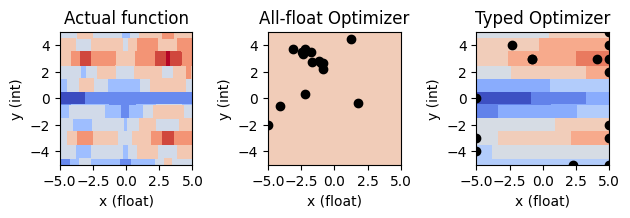

In [8]:
x = np.linspace(c_pbounds['x'][0], c_pbounds['x'][1], 1000)
y = np.linspace(c_pbounds['y'][0], c_pbounds['y'][1], 1000)

X, Y = np.meshgrid(x, y)

Z = discretized_function(X, Y)

params = [{'x': x_i, 'y': y_j} for y_j in y for x_i in x]
array_params = [continuous_optimizer._space.params_to_array(p) for p in params]
c_pred = continuous_optimizer._gp.predict(array_params).reshape(X.shape)
d_pred = discrete_optimizer._gp.predict(array_params).reshape(X.shape)

vmin = np.min([np.min(Z), np.min(c_pred), np.min(d_pred)])
vmax = np.max([np.max(Z), np.max(c_pred), np.max(d_pred)])

fig, axs = plt.subplots(1, 3)

axs[0].set_title('Actual function')
axs[0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)


axs[1].set_title(labels[0])
axs[1].contourf(X, Y, c_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[1].scatter(continuous_optimizer._space.params[:,0], continuous_optimizer._space.params[:,1], c='k')

axs[2].set_title(labels[1])
axs[2].contourf(X, Y, d_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[2].scatter(discrete_optimizer._space.params[:,0], discrete_optimizer._space.params[:,1], c='k')

def make_plot_fancy(ax: plt.Axes):
    ax.set_aspect("equal")
    ax.set_xlabel('x (float)')
    ax.set_xticks([-5.0, -2.5, 0., 2.5, 5.0])
    ax.set_ylabel('y (int)')
    ax.set_yticks([-4, -2, 0, 2, 4])

for ax in axs:
    make_plot_fancy(ax)

plt.tight_layout()
plt.show()

## 3. Categorical variables


We can also handle categorical variables! This is done under-the-hood by constructing parameters in a one-hot-encoding representation, with a transformation in the kernel rounding to the nearest one-hot representation. If you want to use this, you can specify a collection of strings as options.

NB: As internally, the categorical variables are within a range of `[0, 1]` and the GP used for BO is by default isotropic, you might want to ensure your other features are similarly scaled to a range of `[0, 1]` or use an anisotropic GP.

In [9]:
def f1(x1, x2):
    return -1*(x1 - np.sqrt(x1**2 + x2**2) * np.cos(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def f2(x1, x2):
    return -1*(x2 - np.sqrt(x1**2 + x2**2) * np.sin(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def SPIRAL(x1, x2, k):
    """cf Ladislav-Luksan
    """
    if k=='1':
        return f1(10 * x1, 10 * x2)
    elif k=='2':
        return f2(10 * x1, 10 * x2)


In [10]:
pbounds = {'x1': (-1, 1), 'x2': (-1, 1), 'k': ('1', '2')}

categorical_optimizer = BayesianOptimization(
    f=SPIRAL,
    #acquisition_function=acquisition.ExpectedImprovement(1e-2),
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)
discrete_optimizer.set_gp_params(alpha=1e-3)

categorical_optimizer.maximize(
        init_points=2,
        n_iter=18,
    )

/var/folders/r0/12hxq7zs2mx5kr76ks1_n9k80000gn/T/ipykernel_63433/2996397825.py:3: UserWarning: Non-float parameters are experimental and may not work as expected. Exercise caution when using them and please report any issues you encounter.
  categorical_optimizer = BayesianOptimization(


|   iter    |  target   |    x1     |    x2     |     k     |
-------------------------------------------------------------
| 1         | -2.052    | -0.165955 | 0.4406489 | 2         |
| 2         | 13.49     | -0.743751 | 0.9980810 | 1         |
| 3         | 10.26     | -0.734149 | 0.9535175 | 1         |
| 4         | -16.13    | -0.746244 | 0.9996268 | 2         |
| 5         | 3.259     | -0.123283 | -0.574741 | 1         |
| 6         | -7.048    | 0.3920786 | 0.6459259 | 1         |
| 7         | -3.913    | 0.4586377 | -0.324596 | 1         |
| 8         | 5.802     | -0.691390 | 0.2097127 | 1         |
| 9         | 1.222     | -0.833528 | 0.0859457 | 2         |
| 10        | 4.208     | -0.290231 | -0.196824 | 1         |
| 11        | -4.159    | -0.615341 | 0.8791598 | 2         |
| 12        | -4.333    | -0.635647 | 0.1409021 | 2         |
| 13        | 3.66      | 0.0660672 | -0.921962 | 1         |
| 14        | 1.083     | 0.5054393 | 0.0720508 | 2         |
| 15    

In [11]:
res = categorical_optimizer._space.res()
k1 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='1'])
k2 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='2'])

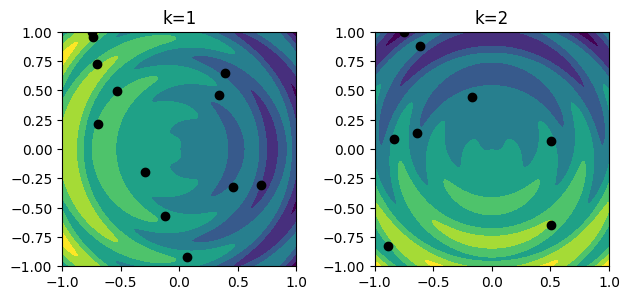

In [15]:
x1 = np.linspace(pbounds['x1'][0], pbounds['x1'][1], 1000)
x2 = np.linspace(pbounds['x2'][0], pbounds['x2'][1], 1000)

X1, X2 = np.meshgrid(x1, x2)
Z1 = SPIRAL(X1, X2, '1')
Z2 = SPIRAL(X1, X2, '2')

fig, axs = plt.subplots(1, 2)

vmin = np.min([np.min(Z1), np.min(Z2)])
vmax = np.max([np.max(Z1), np.max(Z2)])

axs[0].contourf(X1, X2, Z1, vmin=vmin, vmax=vmax)
axs[0].set_aspect("equal")
axs[0].scatter(k1[:,0], k1[:,1], c='k')
axs[1].contourf(X1, X2, Z2, vmin=vmin, vmax=vmax)
axs[1].scatter(k2[:,0], k2[:,1], c='k')
axs[1].set_aspect("equal")
axs[0].set_title('k=1')
axs[1].set_title('k=2')
fig.tight_layout()


## 4. Use in ML

A typical usecase for integer and categorical parameters is optimizing the hyperparameters of a machine learning model. Below you can find an example where the hyperparameters of an SVM are optimized.

In [13]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

data = load_breast_cancer()
X_train, y_train = data['data'], data['target']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
kernels = ['rbf', 'poly']

def f_target(kernel, log10_C):
    if kernel == 'poly2':
        kernel = 'poly'
        degree = 2
    elif kernel == 'poly3':
        kernel = 'poly'
        degree = 3
    elif kernel == 'rbf':
        degree = 3 # not used, equal to default

    C = 10**log10_C

    model = SVC(C=C, kernel=kernel, degree=degree, probability=True, random_state=1)
    model.fit(X_train, y_train)

    # Package looks for maximum, so we return -1 * log_loss
    loss = -1 * log_loss(y_val, model.predict_proba(X_val))
    return loss


params_svm ={
    'kernel': ['rbf', 'poly2', 'poly3'],
    'log10_C':(-1, +1),
}

optimizer = BayesianOptimization(
    f_target,
    params_svm,
    random_state=1,
    verbose=2
)

kernel = Matern(nu=2.5, length_scale=np.ones(optimizer.space.dim))
discrete_optimizer.set_gp_params(kernel=kernel)
optimizer.maximize(init_points=2, n_iter=8)

/var/folders/r0/12hxq7zs2mx5kr76ks1_n9k80000gn/T/ipykernel_63433/3228056642.py:37: UserWarning: Non-float parameters are experimental and may not work as expected. Exercise caution when using them and please report any issues you encounter.
  optimizer = BayesianOptimization(


|   iter    |  target   |  kernel   |  log10_C  |
-------------------------------------------------
| 1         | -0.2361   | poly2     | 0.9943696 |
| 2         | -0.2864   | rbf       | -0.999771 |
| 3         | -0.2625   | poly3     | 0.7449728 |
| 4         | -0.2361   | poly2     | 0.9944598 |
| 5         | -0.298    | poly3     | -0.999625 |
| 6         | -0.2361   | poly2     | 0.9945010 |
| 7         | -0.2152   | rbf       | 0.9928960 |
| 8         | -0.2153   | rbf       | 0.9917667 |
| 9         | -0.2362   | poly2     | 0.9897298 |
| 10        | -0.2362   | poly2     | 0.9874217 |


## 5. Defining your own Parameter

Maybe you want to optimize over another form of parameters, which does not align with `float`, `int` or categorical. For this purpose, you can create your parameter.

As an example, consider a parameter that is discrete, but still admits a distance representation (like an integer) while not being uniformly spaced.

In [ ]:
from bayes_opt.parameter import BayesParameter


class MyParameter(BayesParameter):
    def __init__(self, name: str, bounds) -> None:
        super().__init__(name, bounds)

    def is_continuous(self):
        return False
    
        